<a href="https://colab.research.google.com/github/pratapsinghadarsh/neural-style-transfer/blob/main/NST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing all the necessary Libraries**

In [21]:

import numpy as np
import os
import cv2
import ctypes
import tensorflow as tf
from tensorflow.keras.application import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


**Loading an image and converting the image into a Tensor**

In [22]:
def load_image(image_path,max_length):

    if os.path.exists(image_path):
        image = cv2.imread(image_path)

        height,width = image.shape[0:2]

        if (height>width):
            if (height>max_length):
                width = int(width*(max_length/height))
                height = max_length
                image = cv2.resize(image,(width,height),interpolation=cv2.INTER_AREA)
        else:
            if (width>max_length):
                height = int(height*(max_length/width))
                width = max_length
                image = cv2.resize(image,(width,height),interpolation=cv2.INTER_AREA)

        image_rgb = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image_rgb = np.expand_dims(image_rgb,axis=0)
        image_tensor = tf.convert_to_tensor(image_rgb)
        image_tensor = tf.cast(image_tensor,tf.float32)
        image_tensor = image_tensor/255.

        return image_tensor
    else:
        raise OSError('Invalid Image path!')

In [23]:
image = load_image('san_diego_temple.jpg',512)
print(image.shape)

(1, 341, 512, 3)


**Feature Extraction from style and content images**

In [24]:
def create_feature_extractor(convnet,style_layers,content_layers):
        layers = style_layers+content_layers
        outputs = [convnet.get_layer(layer_name).output for layer_name in layers]
        model = tf.keras.models.Model(convnet.inputs,outputs)

        return model


content_layers = ['block4_conv2']
style_layers = ['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']

convnet = VGG19(include_top=False,weights='imagenet')
feature_extractor = create_feature_extractor(convnet,style_layers,content_layers)
feature_extractor.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

**Gram Matrix**

In [25]:
def gram_matrix(tensor):
        shape = tensor.get_shape()
        num_channels = int(shape[3])
        matrix = tf.reshape(tensor, shape=[-1, num_channels])
        gram = tf.expand_dims(tf.matmul(tf.transpose(matrix), matrix),axis=0)

        return gram


temp_input_tensor = tf.constant(np.random.randn(1,5,5,512))
gram_matrix_tensor = gram_matrix(temp_input_tensor)
print(gram_matrix_tensor.shape)

(1, 512, 512)


**Loss function for NST**

In [26]:

def loss(outputs,style_features,content_features,style_weight,content_weight):
        style_outputs = outputs[0]
        content_outputs = outputs[1]

        style_loss = []
        for index,style_output in enumerate(style_outputs):
            loss = tf.reduce_mean((style_output - style_features[index])**2)
            style_loss.append(loss)

        style_loss = tf.add_n(style_loss)
        style_loss *= style_weight


        content_loss = []
        for index,content_output in enumerate(content_outputs):
            loss = tf.reduce_mean((content_output - content_features[index])**2)
            content_loss.append(loss)

        content_loss = tf.add_n(content_loss)
        content_loss *= content_weight

        loss = style_loss + content_loss
        return loss

**Generate Image**

In [27]:
class style_transfer(tf.keras.models.Model):

    def __init__(self,convnet,input_preprocessor,style_layers,content_layers,style_weight,content_weight):

        super(style_transfer, self).__init__()

        self.feature_extractor = self.create_feature_extractor(convnet,style_layers,content_layers)
        self.feature_extractor.trainable = False
        self.input_preprocessor_ = input_preprocessor
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.style_weight = style_weight/self.num_style_layers
        self.content_weight = content_weight/len(content_layers)


    def call(self,inputs):

        inputs = inputs*255
        preprocessed_inputs = self.input_preprocessor_(inputs)

        outputs = self.feature_extractor(preprocessed_inputs)
        style_outputs = outputs[:self.num_style_layers]
        content_outputs = outputs[self.num_style_layers:]

        style_outputs = [self.gram_matrix(style_output) for style_output in style_outputs]

        return [style_outputs,content_outputs]


    @staticmethod
    def create_feature_extractor(convnet,style_layers,content_layers):
        layers = style_layers+content_layers
        outputs = [convnet.get_layer(layer_name).output for layer_name in layers]
        model = tf.keras.models.Model(convnet.inputs,outputs)

        return model

    @staticmethod
    def gram_matrix(tensor):
        shape = tensor.get_shape()
        num_channels = int(shape[3])
        matrix = tf.reshape(tensor, shape=[-1, num_channels])
        gram = tf.expand_dims(tf.matmul(tf.transpose(matrix), matrix),axis=0)

        return gram

    @staticmethod
    def loss(outputs,style_features,content_features,style_weight,content_weight):
        style_outputs = outputs[0]
        content_outputs = outputs[1]

        style_loss = []
        for index,style_output in enumerate(style_outputs):
            loss = tf.reduce_mean((style_output - style_features[index])**2)
            style_loss.append(loss)

        style_loss = tf.add_n(style_loss)
        style_loss *= style_weight


        content_loss = []
        for index,content_output in enumerate(content_outputs):
            loss = tf.reduce_mean((content_output - content_features[index])**2)
            content_loss.append(loss)

        content_loss = tf.add_n(content_loss)
        content_loss *= content_weight

        loss = style_loss + content_loss
        return loss


    @staticmethod
    def clip_pixels(image):
        clipped_image = tf.clip_by_value(image,clip_value_min = 0.0,clip_value_max = 1.0)
        return clipped_image

**A function to convert TensorFlow tensor to Image**

In [28]:
def tensor_to_image(tensor):
		tensor = tensor * 255
		tensor = np.array(tensor, dtype=np.uint8)

		if np.ndim(tensor) > 3:
			tensor = tensor[0]

		return Image.fromarray(tensor)

**Defining content-layers and style-layers.**

In [29]:
content_layers = ['block4_conv2']
style_layers = ['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']

style_weight = 20.0
content_weight = 1e7
tv_weight = 10.0

epochs = 5
steps_per_epoch = 50

**We make folders/directories for style,content,generated image in our drive**

In [30]:
if not os.path.exists('drive/MyDrive/neural_style_transfer'):
  os.mkdir('drive/MyDrive/neural_style_transfer')

if not os.path.exists('drive/MyDrive/neural_style_transfer/content'):
  os.mkdir('drive/MyDrive/neural_style_transfer/content')

if not os.path.exists('drive/MyDrive/neural_style_transfer/style'):
  os.mkdir('drive/MyDrive/neural_style_transfer/style')

if not os.path.exists('drive/MyDrive/neural_style_transfer/outputs'):
  os.mkdir('drive/MyDrive/neural_style_transfer/outputs')

if not os.path.exists('drive/MyDrive/neural_style_transfer/outputs/intermediate'):
  os.mkdir('drive/MyDrive/neural_style_transfer/outputs/intermediate')

if not os.path.exists('drive/MyDrive/neural_style_transfer/outputs/final'):
  os.mkdir('drive/MyDrive/neural_style_transfer/outputs/final')

**Define the path to content, style and generated image**

In [31]:
content_image_path = 'drive/MyDrive/neural_style_transfer/content/san_diego_temple.jpg'
style_image_path = 'drive/MyDrive/neural_style_transfer/style/modern_art.jpg'
final_output_path = 'drive/MyDrive/neural_style_transfer/outputs/final/'
intermediate_output_path = 'drive/MyDrive/neural_style_transfer/outputs/intermediate/'

**Loading content and style image**

In [32]:
content_image = load_image(content_image_path,512)
style_image = load_image(style_image_path,512)

Content_image size: (1, 341, 512, 3)
Style_image size: (1, 512, 415, 3)


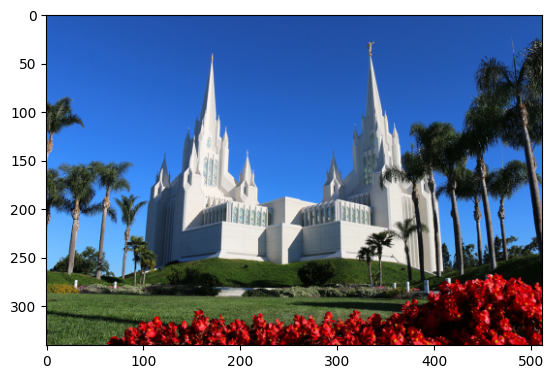

In [33]:
print('Content_image size:',content_image.shape)
print('Style_image size:',style_image.shape)
plt.imshow(tensor_to_image(content_image))


**Loading Predefined convnet and creating feature extractor and also loading the optimizer**

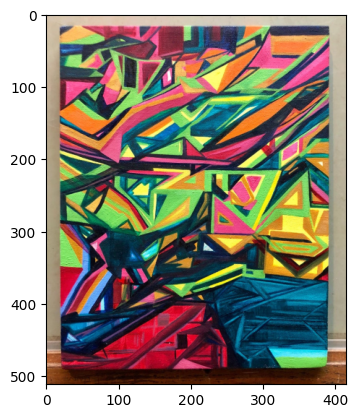

In [34]:
plt.imshow(tensor_to_image(style_image))

In [35]:
convnet = VGG19(include_top=False,weights='imagenet')

nst = style_transfer(convnet,preprocess_input,style_layers,content_layers,style_weight,content_weight)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01,beta_1=0.99,epsilon=1e-1)

In [36]:

style_features = nst(style_image)[0]
content_features = nst(content_image)[1]


In [37]:
generated_image = tf.Variable(content_image)

**Define path to final and intermediate outputs**

In [38]:
style_image_name = style_image_path.split('/')[-1].split('.')[0]
content_image_name = content_image_path.split('/')[-1].split('.')[0]

if not os.path.exists(intermediate_output_path+content_image_name+'_'+style_image_name):
  os.mkdir(intermediate_output_path+content_image_name+'_'+style_image_name)

**Training step**

In [39]:

@tf.function
def train_step(image,nst,optimizer,style_features,content_features,tv_weight):

    with tf.GradientTape() as tape:
        outputs = nst(image)
        loss = nst.loss(outputs,style_features,content_features,nst.style_weight,nst.content_weight)
        loss += tv_weight * tf.image.total_variation(image)

    gradients = tape.gradient(loss,image)
    optimizer.apply_gradients([(gradients,image)])
    image.assign(nst.clip_pixels(image))


generated_image = tf.Variable(content_image)


for epoch in range(epochs):
  for step in range(steps_per_epoch):

    train_step(generated_image,nst,optimizer,style_features,content_features,tv_weight)
  print(f'\nEpoch: {epoch+1}\nTotal Steps: {(epoch+1)*steps_per_epoch}')

  tensor_to_image(generated_image).save(intermediate_output_path+content_image_name+'_'+style_image_name+'/'+str(epoch+1)+'.jpg')

print('\nSaving Final Image:')
tensor_to_image(generated_image).save(final_output_path+content_image_name+'_'+style_image_name+'.jpg')
print('Final Image Saved')



Epoch: 1
Total Steps: 50

Epoch: 2
Total Steps: 100

Epoch: 3
Total Steps: 150

Epoch: 4
Total Steps: 200

Epoch: 5
Total Steps: 250

Saving Final Image:
Final Image Saved


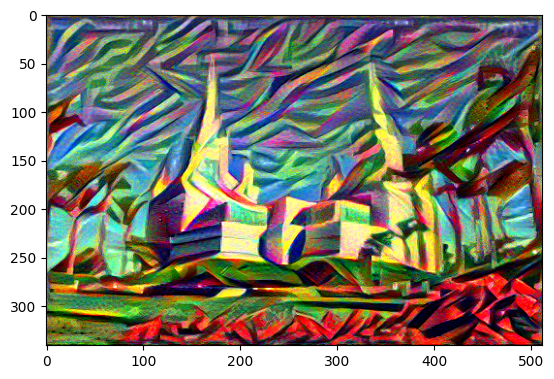

In [40]:

plt.imshow(tensor_to_image(generated_image))
